In [1]:
#import numpy, scipy, math and astropy libraries
import numpy as np
import scipy as sp
import math
import astropy
from astropy.io import ascii
from astropy.table import Table, Column
import pandas

#import packages to use stephanie's fit_rossby.py
import numpy as np
import emcee
import corner
import ellc

#import packages for making corner plot
from emcee.autocorr import function as autocorr_function

ModuleNotFoundError: No module named 'ellc'

In [2]:
#import graphics packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

<IPython.core.display.Javascript object>


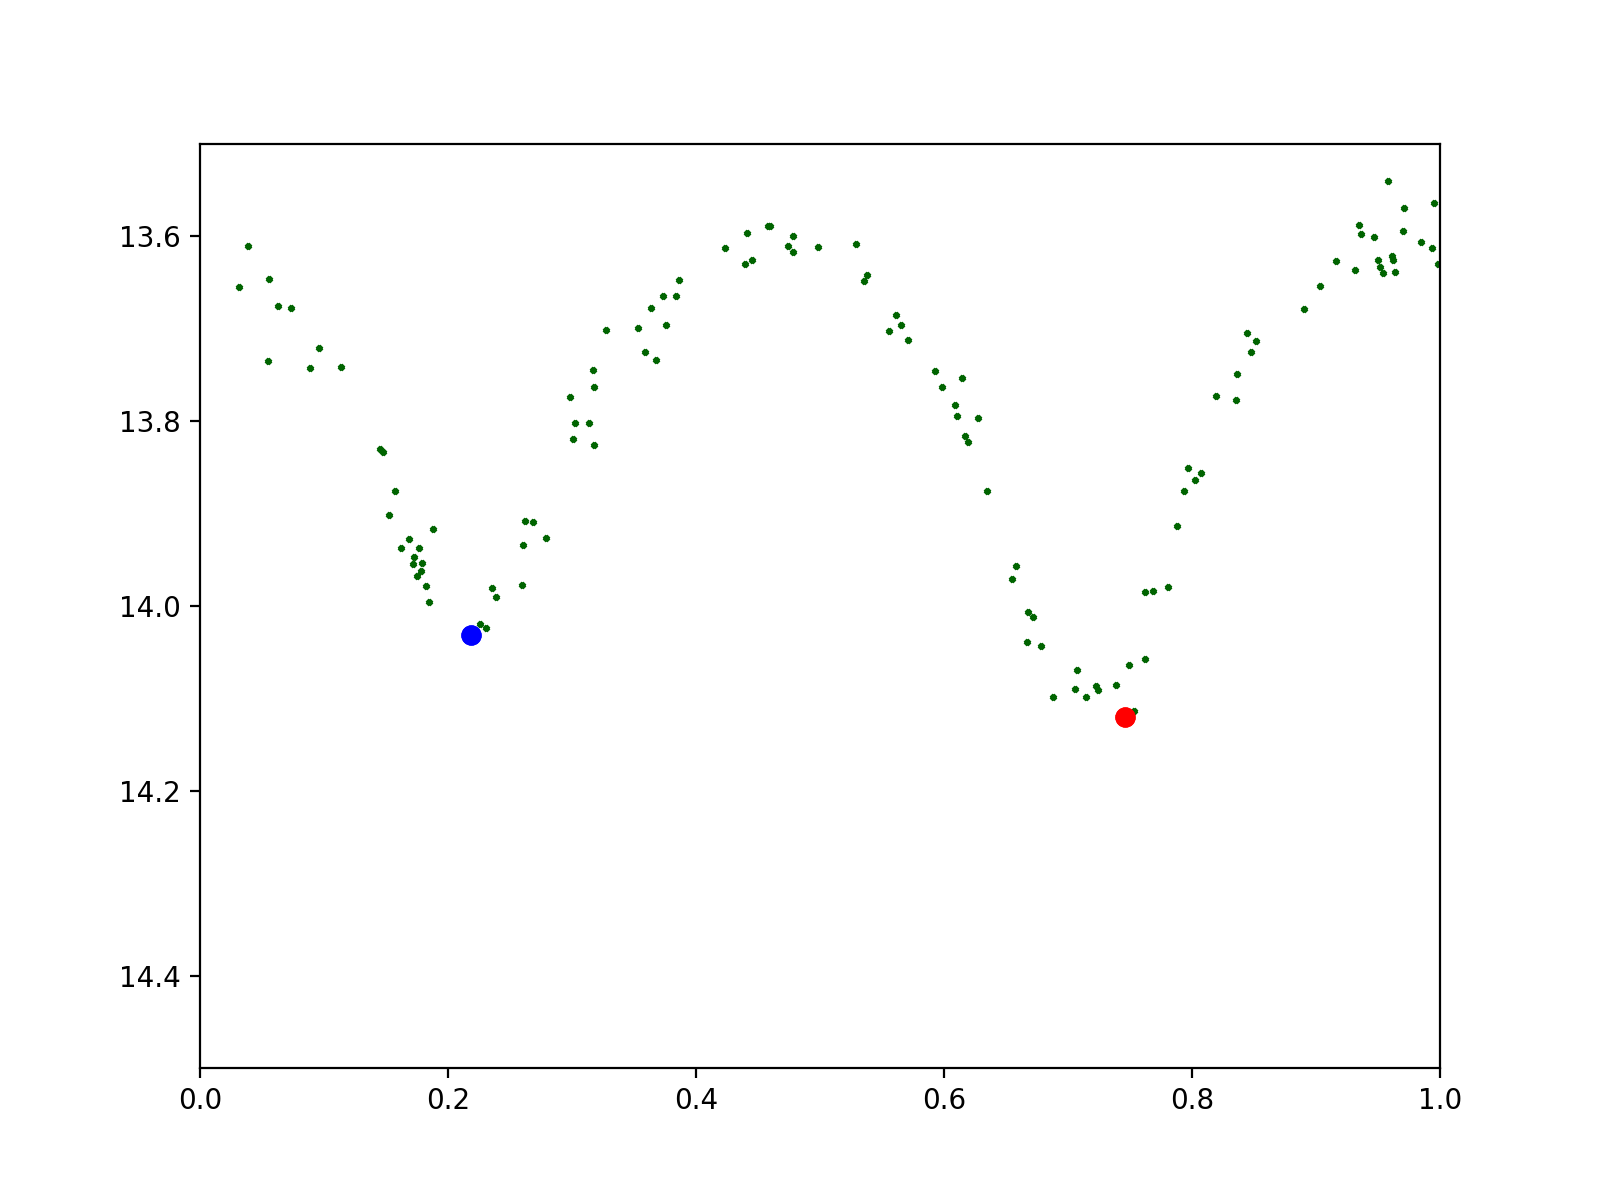

In [7]:
#read in the light curve
LC = Table.read("2M04403927+3306187.LC.csv", data_start=1, delimiter=',')
#LC.info()

#define the period and calculate phase
period = 0.40158
phase = Column((LC['hjd'] % period) / period, name='phase')

#compute a simpler JD
simpleJD = Column(np.asarray(LC['hjd']) - np.ones(len(LC['hjd']))*2457000., name='simpleJD')

#create a flag column; later we can get fancy if we want to omit some points
flag = Column(np.ones(len(LC['hjd'])), name='flag')

#create a version of the table to output for ellc
LC.add_column(simpleJD, index=0)
LC.remove_columns(['hjd', 'camera','filter','flux (mJy)', 'flux err'])
LC.add_column(flag)
LC.add_column(phase)

#LC.info()

#write out light curve in format that ellc can read in for fitting
ascii.write(LC, '2M04403927+3306187.dat')

#find the location of the maximum magnitude value (which corresponds to the deepest eclipse)
primary_eclipse = np.argmax(LC['mag'])
phase_of_primary_eclipse = LC['phase'][primary_eclipse]
mag_of_primary_eclipse = LC['mag'][primary_eclipse]

#now search for phases that are within 0.2 of this phase, and create a copy of the magnitude 
#array that has the values within 0.2 in phase set them to -99.
mags_for_secondary = np.where( (LC['phase'] > phase_of_primary_eclipse - 0.2) & (LC['phase'] < phase_of_primary_eclipse + 0.2), -99, LC['mag'])

#now search this new magnitude array for its' maximum -- since the values near the primary have been 
#'masked' to -99., they won't be identified as the maximum, so we should usually get the secondary eclipse
secondary_eclipse = np.argmax(mags_for_secondary)
phase_of_secondary_eclipse = LC['phase'][secondary_eclipse]
mag_of_secondary_eclipse = LC['mag'][secondary_eclipse]

#print(LC['phase'][secondary_eclipse])

fig=plt.figure(1,figsize=(8,6))

plt.scatter(LC['phase'],LC['mag'],color='darkgreen',marker='x',s=3)
plt.scatter([phase_of_primary_eclipse, phase_of_primary_eclipse], [mag_of_primary_eclipse, mag_of_primary_eclipse],color='red',marker='o',s=40)
plt.scatter([phase_of_secondary_eclipse, phase_of_secondary_eclipse], [mag_of_secondary_eclipse, mag_of_secondary_eclipse],color='blue',marker='o',s=40)
plt.xlim([0,1.0])
plt.ylim([14.5,13.5])

plt.savefig('2M0440_LC_MarkPrimary+Secondary.jpg', bbox_inches='tight') 
#plt.close()

RMS residual = 26.997


<IPython.core.display.Javascript object>


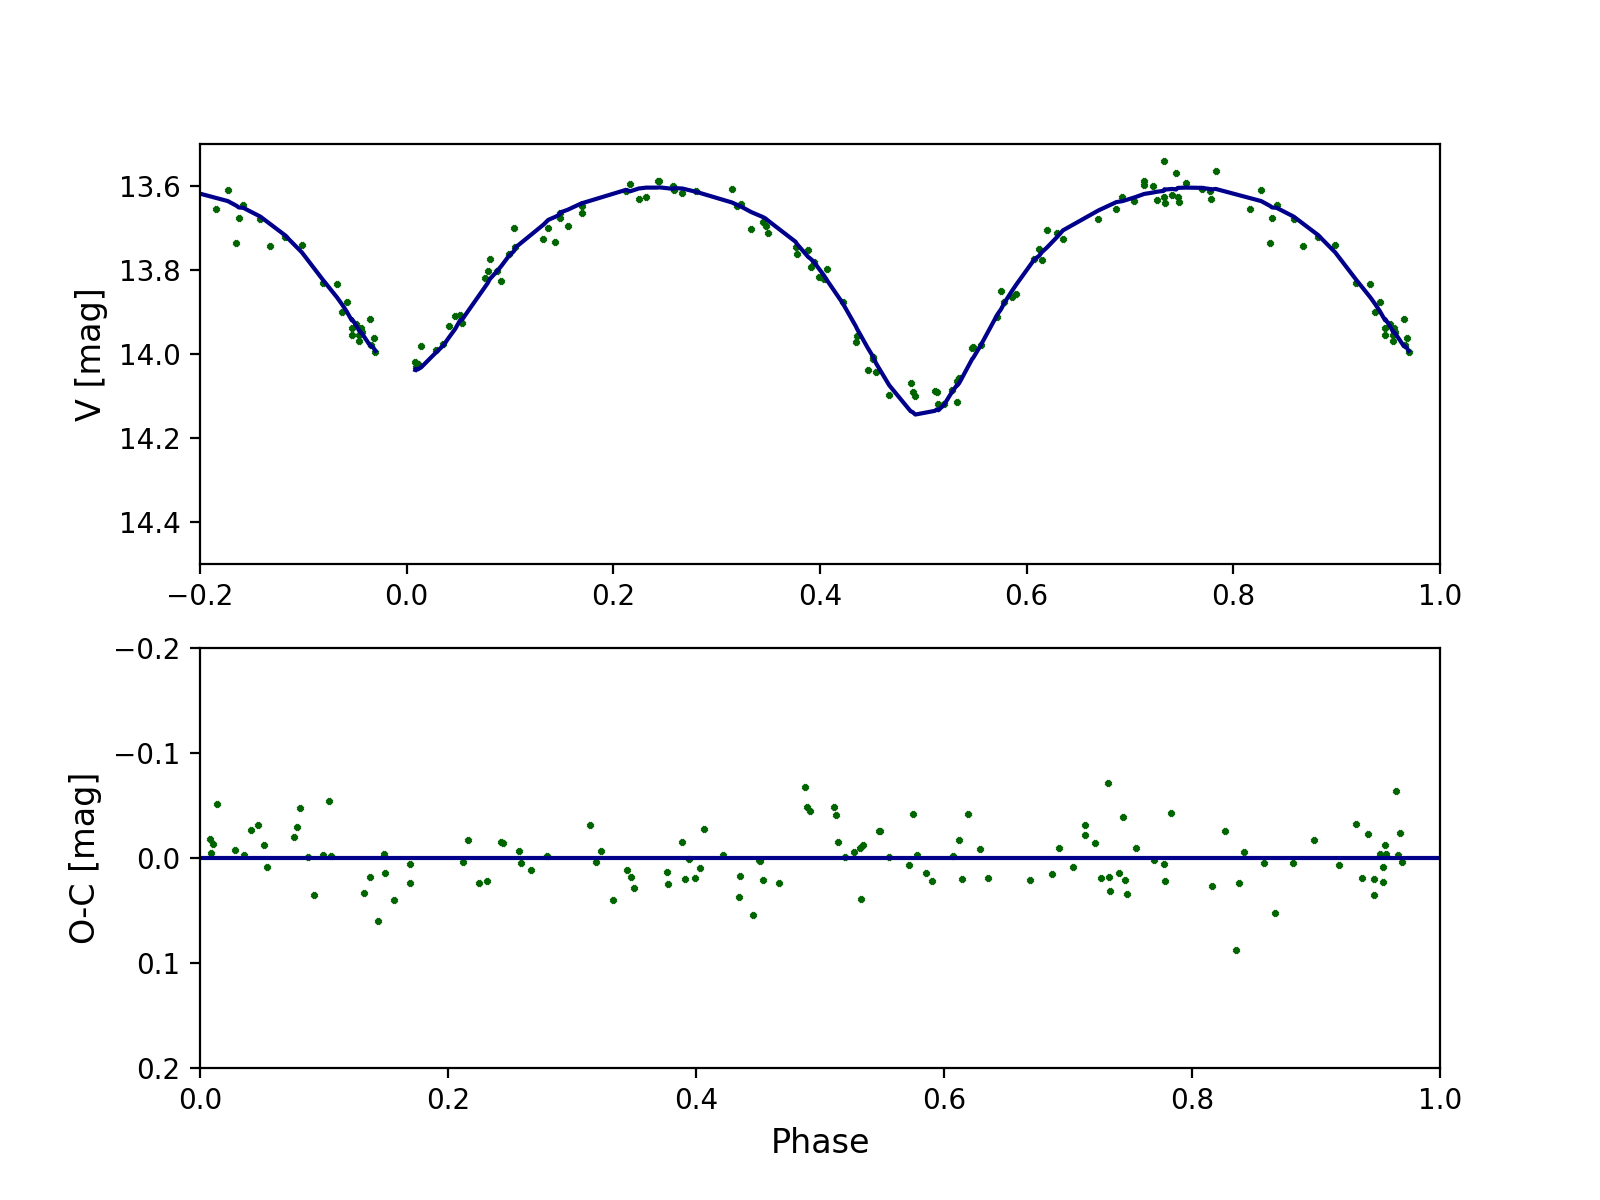

In [9]:
#read in the model that I computed from ellc_emcee [more on this soon!]
model = Table.read('model.csv')
model = Table(model, masked=True)

mask = model['flag'] < 0 

ph_obs = np.extract(mask == False,model['phase']) 
m_obs = np.extract(mask == False,model['mag'])
m_fit = np.extract(mask == False,model['fit'])
m_res = m_obs - m_fit
print ('RMS residual = {0:0.3f}'.format(1000*np.std(m_res)))
ph_plt = np.array(model['phase']) 
f_plt = np.array(model['fit'])
i_sort = np.argsort(ph_plt)
ph_plt = ph_plt[i_sort]
f_plt  = f_plt[i_sort]

fig=plt.figure(1,figsize=(8,6))

fontsize = 12

plt.subplot(211)
plt.scatter(ph_obs,m_obs,color='darkgreen',marker='x',s=3)
plt.scatter(ph_obs-1,m_obs,color='darkgreen',marker='x',s=3)
plt.plot(ph_plt,f_plt,color='darkblue')
plt.plot(ph_plt-1,f_plt,color='darkblue')
# plt.scatter(ph_obs,m_res-0.01,color='darkgreen',marker='x',s=3)
# plt.scatter(ph_obs-1,m_res-0.01,color='darkgreen',marker='x',s=3)
# plt.plot([-0.08,0.08],[-0.01,-0.01],':',color='darkblue')
plt.ylabel("V [mag]",fontsize=fontsize)
plt.xlim([-0.2,1.0])
plt.ylim([14.5,13.5])

plt.subplot(212)
plt.scatter(ph_obs,m_res,color='darkgreen',marker='x',s=3)
plt.scatter(ph_obs-1,m_res,color='darkgreen',marker='x',s=3)
plt.plot([-0.35,1.0],[0,0],color='darkblue')
plt.ylabel("O-C [mag]",fontsize=fontsize)
plt.xlabel("Phase",fontsize=fontsize)
plt.xlim([0,1.0])
plt.ylim([0.2,-0.2])

plt.savefig('2M0440_LC_wModel.jpg', bbox_inches='tight') 
#plt.close()

In [11]:
def _autocorrelation_length(v):
  """
  Estimate the autocorrelation length of a time series

  Finds the point where the autocorrelation function drops to e^-1
  """
  x = np.arange(len(v))
  acf = autocorr_function(v)
  return np.argmax(x[acf > np.exp(-1)])

In [16]:
#set burn in factor manually
burn_in_factor = 12

chain = Table.read('chain.csv')
chain = Table(chain, masked=True)

nwalkers = 1+np.max(chain['walker'])
nsteps = 1+np.max(chain['step'])
print('Read chain.csv with {:d} walkers of {:d} steps'.format(nwalkers,nsteps))

step = chain['step']
walker = chain['walker']
chain.remove_column('step')
chain.remove_column('walker')
chain.remove_column('loglike')
lrat = chain['sb2']*(chain['r_2']/chain['r_1'])**2
chain.add_column(Column(lrat,name='lrat'))

ndim = len(chain.colnames)
  
acl = np.zeros([ndim,nwalkers],dtype=int)
print('\nCalculating autocorrelation length of chains for each walker.')
print('  For each parameter, results are quoted as median and range.')   
for icol,colname in enumerate(chain.colnames):
  p =  (chain[colname]).reshape([nwalkers,nsteps])
  for ii in range(0,nwalkers):
    acl[icol,ii] = _autocorrelation_length(p[ii,:])
  print(' {:s} : {} ({} - {})'.format(colname,
        np.median(acl[icol,:]),np.min(acl[icol,:]),np.max(acl[icol,:])))

burnin = np.zeros(nwalkers,dtype=int)
for ii in range(0,nwalkers):
  burnin[ii] = np.int(burn_in_factor)*np.max(acl[:,ii])
mask = (step == 0)
for ii in range(0,nwalkers):
  mask[walker == ii] = step[walker == ii] < burnin[ii]
nok = len(chain) - len(mask.nonzero()[0])

print ('Calculating results for chains with total of {:d} steps'.format(nok))

print("\n Median and std. dev. of parameter values.")  
for icol,colname in enumerate(chain.colnames):
  p =  np.extract(mask == False,chain[colname])
  if colname == 'T_0' :
    print('{:s} = {:14.6f} +/- {:8.6f}'.format(colname, np.median(p),  np.std(p)))
  elif colname == 'P' :
    print('{:s} = {:12.8f} +/- {:10.8f}'.format(colname, np.median(p),  np.std(p)))
  else:
    print('{:s} = {:10.6g} +/- {:10.6g}'.format(colname, np.median(p),  np.std(p)))

Read chain.csv with 200 walkers of 5000 steps

Calculating autocorrelation length of chains for each walker.
  For each parameter, results are quoted as median and range.
 r_1 : 171.5 (23 - 1083)
 r_2 : 155.0 (18 - 1129)
 sb2 : 224.5 (14 - 1085)
 incl : 119.0 (16 - 1084)
 T_0 : 94.0 (4 - 1093)
 P : 66.0 (1 - 999)
 Teff1 : 209.0 (24 - 1044)
 Teff2 : 230.0 (22 - 1107)
 lrat : 148.0 (0 - 1181)
Calculating results for chains with total of 212396 steps

 Median and std. dev. of parameter values.
r_1 =   0.410425 +/-  0.0364325
r_2 =   0.176329 +/-  0.0181576
sb2 =     1.0188 +/-  0.0690502
incl =    87.4946 +/-    2.87446
T_0 =       0.852932 +/- 0.067311
P =   0.40158195 +/- 0.00219515
Teff1 =    7289.42 +/-     226.19
Teff2 =    16943.1 +/-     7874.6
lrat =   0.188512 +/-   0.935696


<IPython.core.display.Javascript object>


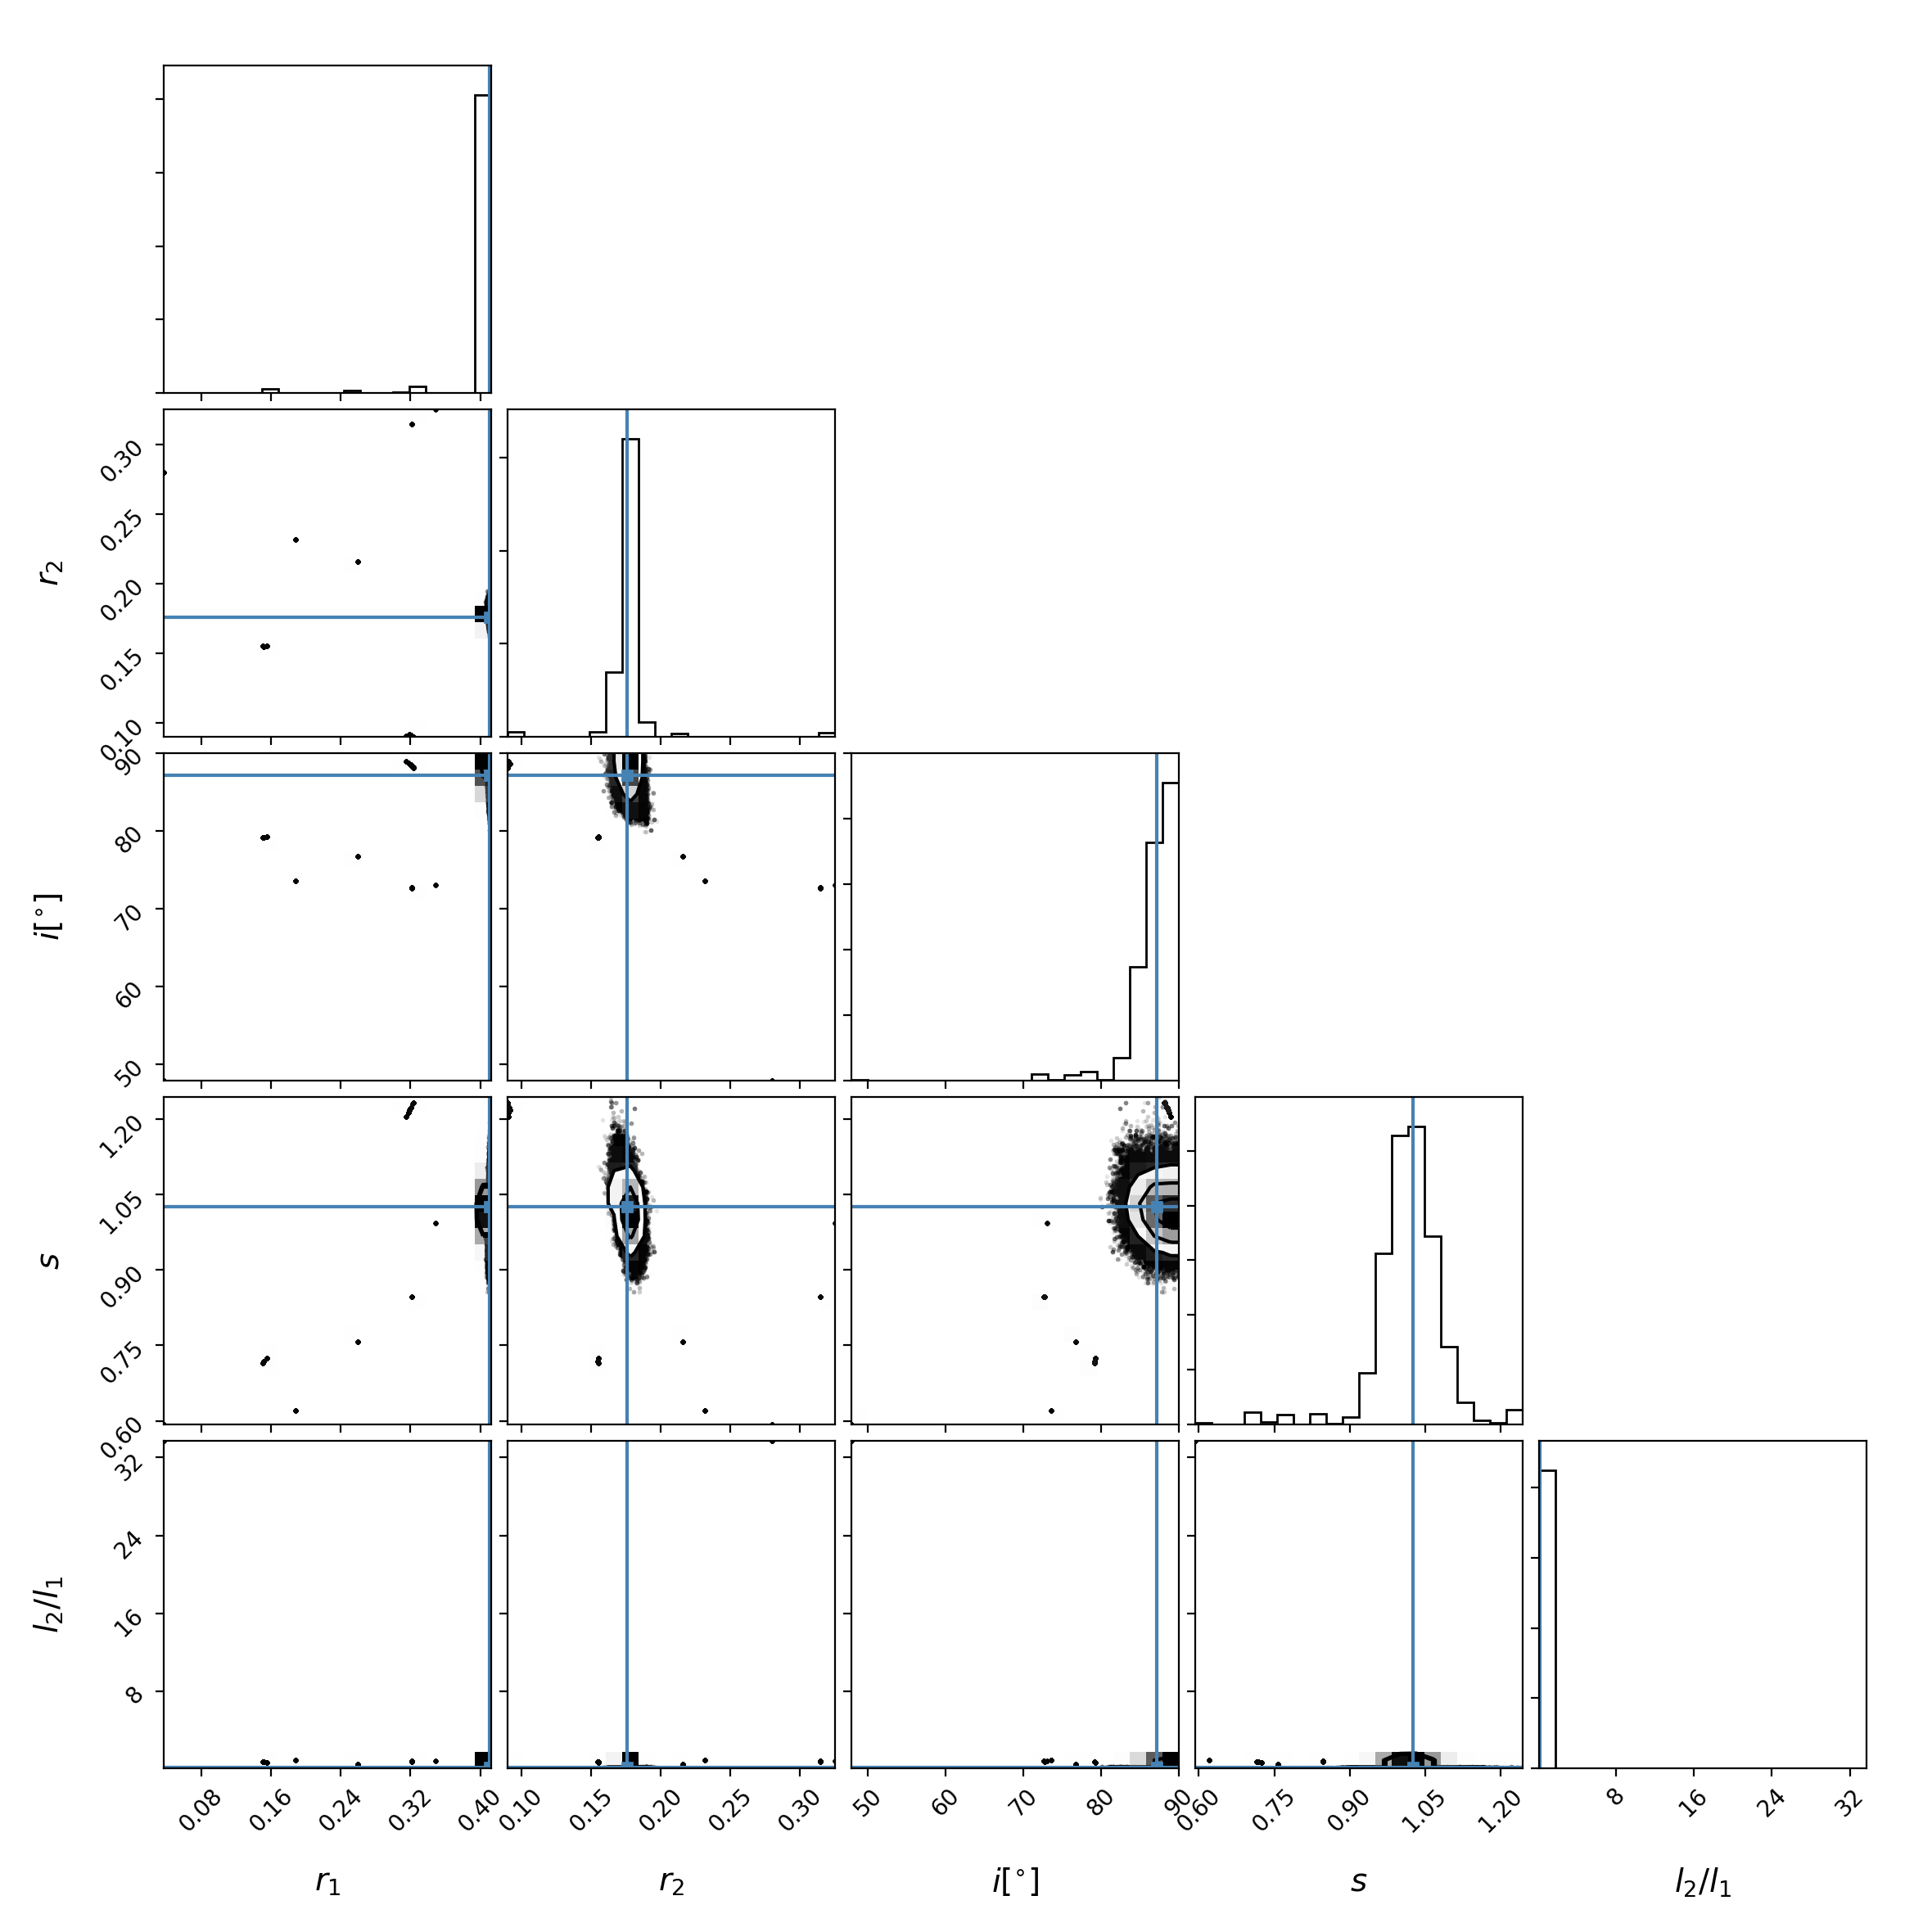

In [17]:
colnames_plot = ['r_1','r_2','incl','sb2','lrat']
labels_plot = ['$r_1$','$r_2$','$i [^{\circ}]$','$s$','$l_2/l_1$']
nplot = len(colnames_plot)
medians = np.zeros(nplot)
samples = np.zeros([nok,nplot])
for ii,colname in enumerate(colnames_plot) :
  p =  np.extract(mask == False,chain[colname])
  samples[:,ii] = p
  medians[ii] = np.median(p)

# Results from chain analysis above
bestFit = [0.4103, 0.1762, 87.18, 1.02665, 0.18857]
# Plot parameter distributions
fig_p = corner.corner(samples, labels=labels_plot, truths=bestFit)
#if args.eps:
fig_p.savefig("corner.jpg")
#else:
#  plt.show()